# Load data

In [3]:
import numpy as np
import pandas as pd
import json
import os
import glob
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as anime
warnings.simplefilter('ignore')
%matplotlib inline

In [4]:
DATA_FOLDER = "../data"
OUTPUT_FOLDER = "./output"
USER_ID = "N01T1"
keypoint_csv = DATA_FOLDER + "/keypoints/{}_keypoint.csv".format(USER_ID)
keypoint_files = glob.glob(os.path.join(DATA_FOLDER, "keypoints","train", "*_keypoint.csv"))

# Processing Data

In [5]:
FS = 30 # sampling rate
TOTAL_CLASSESS = 9
SMOOTH_LEN = 3 # seconds

def load_data(keypoint_csv, ann_csv):
  kp_df = pd.read_csv(keypoint_csv)
  kp_df = kp_df.loc[:, ~kp_df.columns.str.contains('^Unnamed')]

  ann_df = pd.read_csv(ann_csv)
  ann_df = ann_df.loc[:, ~ann_df.columns.str.contains('^Unnamed')]

  return kp_df, ann_df

def remove_redundant_kp(kp_df):
  kp_df = kp_df.loc[:, ~kp_df.columns.str.contains(
      'conf|left_knee|right_knee|left_ankle|right_ankle', regex=True)]
  return kp_df

def smooth_kp(kp_col):
  zero_idx = np.flatnonzero(kp_col == 0)
  split_idx = np.split(zero_idx, np.flatnonzero(np.diff(zero_idx) > 1) + 1)
  for each_split_idx in split_idx:
    if len(each_split_idx) == 0 or each_split_idx[0] == 0 or each_split_idx[-1] == (len(kp_col) - 1) or len(each_split_idx) > SMOOTH_LEN*FS:
      continue
    xp = [each_split_idx[0] - 1, each_split_idx[-1] + 1]
    fp = kp_col[xp]
    interp_kp = np.interp(each_split_idx, xp, fp)
    kp_col[each_split_idx] = interp_kp
  return kp_col

def normalize_data(data):
    # Normalize data to the range [0, 1]
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)

    return normalized_data.fillna(0)

In [9]:
# Generate JSON Format
for keypoint_file in keypoint_files:
    subject_id = os.path.basename(keypoint_file).split("_")[0]
    ann_csv = os.path.join(DATA_FOLDER, "ann", f"{subject_id}_ann.csv")
    if not Path(ann_csv).exists():
      print(f"File: {subject_id}_ann.csv Doesn't Exist")
      continue
    kp_df, ann_df = load_data(keypoint_file, ann_csv)
    kp_df = remove_redundant_kp(kp_df)
    #kp_df = normalize_data(kp_df)

    for i in range(len(kp_df.columns)):
      kp_df.iloc[:, i] = smooth_kp(np.array(kp_df.iloc[:, i]))

    kp_df['label'] = None

    # Assigning Labels to rows within the timeframe
    for index, row in ann_df.iterrows():
        start_time = row['start_time']
        stop_time = row['stop_time']
        label = row['annotation']
        kp_df.loc[start_time * FS:stop_time * FS, 'label'] = label

    array_values = kp_df.to_numpy()
    num_columns = len(kp_df.columns)
    result_list = []  # Each element contains a list of (x,y) tuple coordinates of a body part

    # Convert DataFrame to List holding data from each rows
    for row in array_values:
        temp_list = []
        # Loop through each x,y coord columns
        for i in range(0, num_columns, 2):
            if i + 1 < num_columns:
                temp_list.append([row[i], row[i + 1]])
        result_list.append(temp_list)

    labels = set(array_values[:, -1])
    for label in labels:
        # Find all occurences of that label and get the row (aka list of coords tuple) belong to it
        output = [result_list[idx] for idx, i in enumerate(array_values) if i[-1] == label]
        data = {
            "filename": f"{subject_id}_{label}",
            "skeletons": output,
            "label": label
        }
        output_file = os.path.join(OUTPUT_FOLDER, f"{subject_id}_{label}.json")
        with open(output_file, 'w') as json_file:
            # The JSON File Contain a list of Frames comprise of skeleton points (x,y) coordinates for a specified label from a Nurse
            json.dump(data, json_file)



# Visualization

In [10]:
sk_points = ['nose',
          'left_eye','right_eye',
          'left_ear','right_ear',
          'left_shoulder','right_shoulder',
          'left_elbow','right_elbow',
          'left_wrist','right_wrist',
          'left_hip','right_hip']
neighbor_link = [(0, 1), (0, 2), (2, 4), (1, 3), (4, 6), (3, 5), (6, 8), (5, 7), (8, 10), (7, 9), (6, 12), (5, 11), (6, 5), (12, 11)]

## Single Plot

In [ ]:
def plot_skeleton(value, neighbor_link):
    plt.figure(figsize=(8, 8))
    # Plot Skeleton Line
    plt.scatter(value[:6, 0], value[:6, 1], color='green', marker='o', label='Head')
    plt.scatter(value[5:7, 0], value[5:7, 1], color='red', marker='o', label='Torso')
    plt.scatter(value[11:, 0], value[11:, 1], color='red', marker='o', label='Torso')
    plt.scatter(value[7:11, 0], value[7:11, 1], color='blue', marker='o', label='Limb')
    # Plot Bodyline
    for idx, link in enumerate(neighbor_link):
      if idx < 6: color = 'green'
      elif idx >= 6 and idx < 10: color = 'blue'
      else: color = 'red'
      x_values = [value[link[0], 0], value[link[1], 0]]
      y_values = [value[link[0], 1], value[link[1], 1]]
      plt.plot(x_values, y_values, color=color)
    for idx,point in enumerate(sk_points):
      plt.annotate(point, (value[idx, 0], value[idx, 1]))


    plt.title('Skeleton Model')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

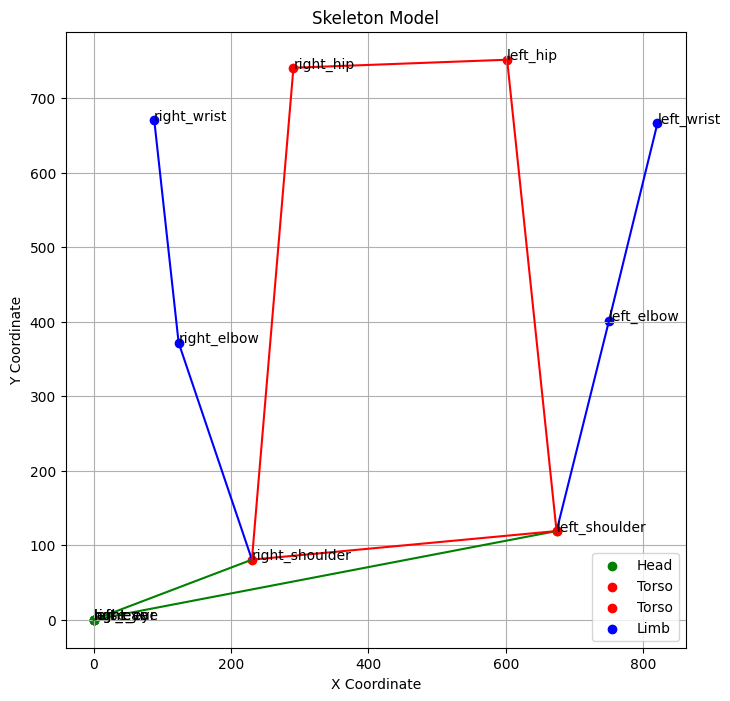

In [ ]:
with open(f'{OUTPUT_FOLDER}/Dataset/N07T1_8.json', 'r') as f:
    json_file = json.load(f)
skeletons = json_file['skeletons']
value = np.array(skeletons)
val = value[20]
plot_skeleton(val, neighbor_link)

## Animation

In [ ]:
# Animate a frame
def animate_skeleton(file_path):
  with open(file_path, 'r') as f:
      json_file = json.load(f)
  skeletons = json_file['skeletons']
  frames = np.array(skeletons)


  title = os.path.basename(file_path)
  plt.figure(figsize=(20, 20))
  plt.title(title)
  plt.ylim(0,1080)
  plt.xlim(0,1920)
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.grid(True)
  fig, ax = plt.subplots()
  plt.gca().invert_yaxis()

  skeleton = frames[0]
  sc = ax.scatter(skeleton[:, 0], skeleton[:, 1], color='blue', marker='o', label='Skeleton Points')
  ann_list = []
  line_list = []
  def animate(i):
      # Clear Previous Frame's plot
      for idx, a in enumerate(ann_list):
          a.remove()
      for idx, l in enumerate(line_list):
          l[0].remove()
      ann_list[:] = []
      line_list[:] = []
      # Update Skeleton Point
      skeleton = frames[i]
      sc.set_offsets(skeleton)
      # Annotate Skeleton Point
      for idx,point in enumerate(sk_points):
        ann = ax.annotate(point, (skeleton[idx, 0], skeleton[idx, 1]))
        ann_list.append(ann)
      # Plot bodyline
      for idx, link in enumerate(neighbor_link):
        if idx < 6: color = 'green'
        elif idx >= 6 and idx < 10: color = 'blue'
        else: color = 'red'
        x_values = [skeleton[link[0], 0], skeleton[link[1], 0]]
        y_values = [skeleton[link[0], 1], skeleton[link[1], 1]]
        line = ax.plot(x_values, y_values, color=color)
        line_list.append(line)
  ani = anime.FuncAnimation(fig, animate,
                            frames=len(frames) - 1,
                            interval=100,
                            repeat=True)

  writer = anime.PillowWriter(fps=30,
                              metadata=dict(artist='Me'),
                              bitrate=1800)
  ani.save(f'{OUTPUT_FOLDER}/{title}.gif', writer=writer)
  return ani



In [ ]:
skeleton_files = glob.glob(os.path.join(OUTPUT_FOLDER, "Dataset", "*.json"))
for json_path in skeleton_files:
    animate_skeleton(json_path)

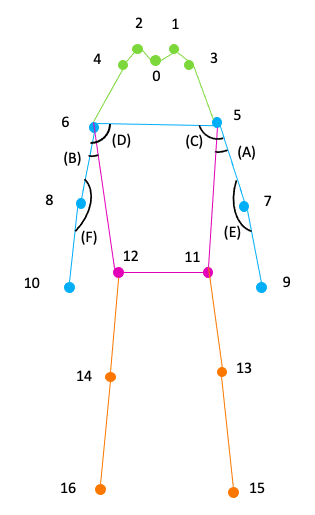

### TODO
Overlap multiple skeleton animation of same label to see how they overlap and the frequented position of their bodypart. Finally produced an overlapped still image for better visualization of position grouping

In [15]:
skeleton_files = glob.glob(os.path.join(OUTPUT_FOLDER, "*.json"))

fig, axs = plt.subplots(3,3,figsize=(20, 20))
for json_path in skeleton_files:
    with open(json_path, 'r') as f:
      json_file = json.load(f)
    skeletons = json_file['skeletons']
    frames = np.array(skeletons)
    label = int(json_file['label'])
    for frame in frames:
      x = int(label/3)
      y = int(label%3)

      # Plot Skeleton Line
      s1 = axs[x][y].scatter(frame[:6, 0], frame[:6, 1], color='green', marker='o', alpha = 0.1, label='Head')
      s2 = axs[x][y].scatter(frame[5:7, 0], frame[5:7, 1], color='red', marker='o', alpha = 0.1, label='Torso')
      s3 = axs[x][y].scatter(frame[11:, 0], frame[11:, 1], color='red', marker='o', alpha = 0.1, label='Torso')
      s4 = axs[x][y].scatter(frame[7:11, 0], frame[7:11, 1], color='blue', marker='o', alpha = 0.1, label='Limb')
      # Plot Bodyline
      # for idx, link in enumerate(neighbor_link):
      #   if idx < 6: color = 'green'
      #   elif idx >= 6 and idx < 10: color = 'blue'
      #   else: color = 'red'
      #   x_values = [frame[link[0], 0], frame[link[1], 0]]
      #   y_values = [frame[link[0], 1], frame[link[1], 1]]
      #   axs[x][y].plot(x_values, y_values, color=color)

      # break # Enable to get First Frame of every dataset
      axs[x][y].set_title(f'Label: {label}')
      plt.legend([s1, (s2,s3), s4],["Head", "Torso", "Limb"])
    # break # Enable to get all frame from first file
plt.savefig(os.path.join(OUTPUT_FOLDER, "Figures", "Label_scatterplot.png"))
plt.show()

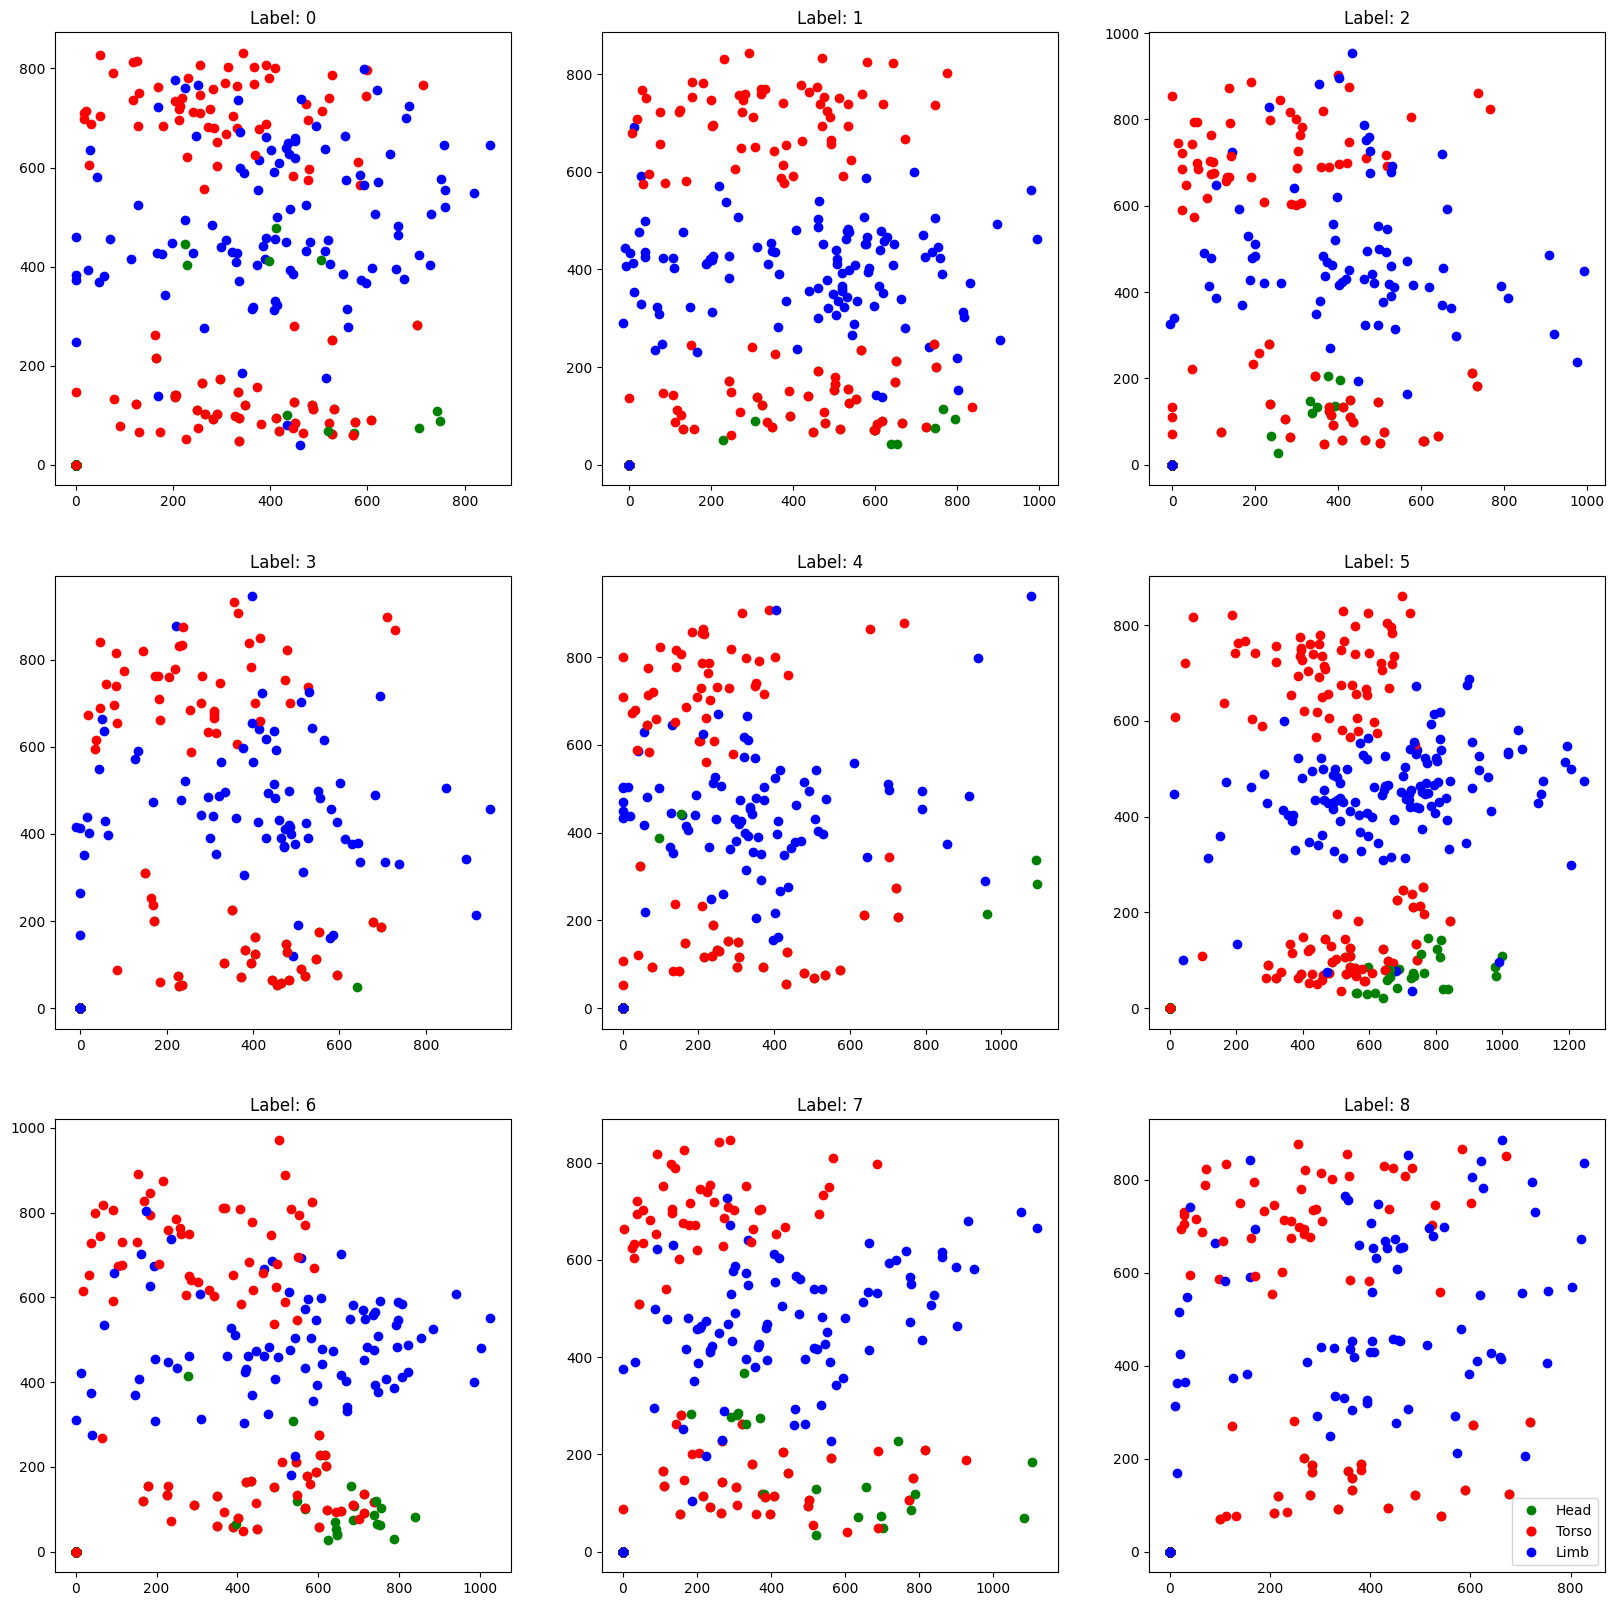

In [ ]:
# WIP INTERACTIVE SCATTERPLOT
# skeleton_files = glob.glob(os.path.join(OUTPUT_FOLDER, "Dataset", "*.json"))

# fig, axs = plt.subplots(3,3,figsize=(20, 20))
# head_dot = []
# torso_dot = []
# limb_dot = []
# for json_path in skeleton_files:
#     with open(json_path, 'r') as f:
#       json_file = json.load(f)
#     skeletons = json_file['skeletons']
#     frames = np.array(skeletons)
#     label = int(json_file['label'])
#     for frame in frames:
#       x = int(label/3)
#       y = int(label%3)

#       # Plot Skeleton Line
#       s1, = axs[x][y].plot(frame[:6, 0], frame[:6, 1],linestyle='None', color='green', marker='o', label='Head')
#       s2, = axs[x][y].plot(frame[5:7, 0], frame[5:7, 1], linestyle='None', color='red', marker='o', label='Torso')
#       s3, = axs[x][y].plot(frame[11:, 0], frame[11:, 1], linestyle='None', color='red', marker='o', label='Torso')
#       s4, = axs[x][y].plot(frame[7:11, 0], frame[7:11, 1], linestyle='None', color='blue', marker='o', label='Limb')
#       head_dot.append(s1)
#       torso_dot.append(s2)
#       torso_dot.append(s3)
#       limb_dot.append(s4)
#       axs[x][y].set_title(f'Label: {label}')
#       break

# legends = plt.legend([s1,(s2,s3),s4],['Head','Torso','Limb'])
# head_legend, torso_legend, limb_legend = legends.get_lines()
# head_legend.set_picker(True)
# head_legend.set_pickradius(10)
# torso_legend.set_picker(True)
# torso_legend.set_pickradius(10)
# limb_legend.set_picker(True)
# limb_legend.set_pickradius(10)

# graphs = {}
# graphs[head_legend] = head_dot
# graphs[torso_legend] = torso_dot
# graphs[limb_legend] = limb_dot

# def on_pick(event):
#     legend = event.artist
#     isVisible = legend.get_visible()

#     graphs[legend].set_visible(not isVisible)
#     legend.set_visible(not isVisible)

#     fig.canvas.draw()

# plt.connect('pick_event', on_pick)
# plt.show()


# Dataloader

In [ ]:
import numpy as np
import json
import random
import math
import os
import tqdm

from torch.utils.data import Dataset

In [ ]:
class Feeder(Dataset):
  def __init__(self, root_path):

    self.root_path = root_path
    self.load_data()
    self.bone = [(0, 1), (0, 2), (2, 4), (1, 3), (4, 6), (3, 5), (6, 8), (5, 7), (8, 10), (7, 9), (6, 12), (5, 11), (6, 5), (12, 11)]
    #self.bone = [(0, 1), (0, 2), (0, 5), (0, 6), (0, 11), (0, 12), (1, 3), (2, 4), (5, 7), (7, 9), (6, 8), (8, 10)]
    self.time_steps = 60 #?????????????????????????????????????????????????????????????????????????????????????????

  def load_data(self):
    self.data = []
    self.labels = []
    for file_name in os.listdir(self.root_path):
      data_path = os.path.join(self.root_path, file_name)
      with open(data_path, 'r') as f:
        json_file = json.load(f)
      skeletons = json_file['skeletons']
      label =  json_file['label']
      value = np.array(skeletons)
      self.labels.append(label)
      self.data.append(value)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    label = self.labels[index]
    value = self.data[index]

    random.random()
    center = value[0, :]
    value = value - center

    value = np.reshape(value, (-1, 2))
    value = (value - np.min(value, axis=0)) / (np.max(value, axis=0) - np.min(value, axis=0))

    value = value * 2 - 1
    value = np.reshape(value, (-1, 13, 2))

    data = np.zeros((self.time_steps, 13, 2))

    length = value.shape[0]

    random_idx = random.sample(list(np.arange(length)) * 100, self.time_steps)
    random_idx.sort()
    data[:, :, :] = value[random_idx, :, :]
    data[:, :, :] = value[random_idx, :, :]


    data_bone = np.zeros_like(data)
    for bone_idx in range(len(self.bone)):
        data_bone[:, self.bone[bone_idx][0], :] = data[:, self.bone[bone_idx][0], :] - data[:, self.bone[bone_idx][1], :]
    data = data_bone


    data = np.transpose(data, (2, 0, 1))
    C,T,V = data.shape
    data = np.reshape(data,(C,T,V,1)) #?????????????????????????????????????????????????????????????????????????????????????????


    return data, label, index

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from kornia.losses import focal_loss

import matplotlib.pyplot as plt

In [ ]:
class Graph():
    """ The Graph to model the skeletons extracted by the openpose

    Args:
        strategy (string): must be one of the follow candidates
        - uniform: Uniform Labeling
        - distance: Distance Partitioning
        - spatial: Spatial Configuration
        For more information, please refer to the section 'Partition Strategies'
            in our paper (https://arxiv.org/abs/1801.07455).

        layout (string): must be one of the follow candidates
        - openpose: Is consists of 18 joints. For more information, please
            refer to https://github.com/CMU-Perceptual-Computing-Lab/openpose#output
        - ntu-rgb+d: Is consists of 25 joints. For more information, please
            refer to https://github.com/shahroudy/NTURGB-D

        max_hop (int): the maximal distance between two connected nodes
        dilation (int): controls the spacing between the kernel points

    """

    def __init__(self,
                 layout='abc',
                 strategy='uniform',
                 max_hop=1,
                 dilation=1):
        self.max_hop = max_hop
        self.dilation = dilation

        self.get_edge(layout)
        self.hop_dis = get_hop_distance(
            self.num_node, self.edge, max_hop=max_hop)
        self.get_adjacency(strategy)

    def __str__(self):
        return self.A

    def get_edge(self, layout):
        if layout == 'abc':
            self.num_node = 13
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_link = [(0, 1), (0, 2), (2, 4), (1, 3), (4, 6), (3, 5), (6, 8), (5, 7), (8, 10), (7, 9), (6, 12), (5, 11), (6, 5), (12, 11)]
             #[(0, 1), (0, 2), (0, 5), (0, 6), (0, 11), (0, 12), (1, 3), (2, 4), (5, 7), (7, 9), (6, 8), (8, 10)]
            self.edge = self_link + neighbor_link
            self.center = 0
        else:
            raise ValueError("Do Not Exist This Layout.")

    def get_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_digraph(adjacency)

        if strategy == 'uniform':
            A = np.zeros((1, self.num_node, self.num_node))
            A[0] = normalize_adjacency
            self.A = A
        elif strategy == 'distance':
            A = np.zeros((len(valid_hop), self.num_node, self.num_node))
            for i, hop in enumerate(valid_hop):
                A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis ==
                                                                hop]
            self.A = A
        elif strategy == 'spatial':
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_node, self.num_node))
                a_close = np.zeros((self.num_node, self.num_node))
                a_further = np.zeros((self.num_node, self.num_node))
                for i in range(self.num_node):
                    for j in range(self.num_node):
                        if self.hop_dis[j, i] == hop:
                            if self.hop_dis[j, self.center] == self.hop_dis[
                                    i, self.center]:
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif self.hop_dis[j, self.
                                              center] > self.hop_dis[i, self.
                                                                     center]:
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_root + a_close)
                    A.append(a_further)
            A = np.stack(A)
            self.A = A
        else:
            raise ValueError("Do Not Exist This Strategy")

def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    AD = np.dot(A, Dn)
    return AD

def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD

In [ ]:
class ConvTemporalGraphical(nn.Module):

    """The basic module for applying a graph convolution.

    Args:
        in_channels (int): Number of channels in the input sequence data
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int): Size of the graph convolving kernel
        t_kernel_size (int): Size of the temporal convolving kernel
        t_stride (int, optional): Stride of the temporal convolution. Default: 1
        t_padding (int, optional): Temporal zero-padding added to both sides of
            the input. Default: 0
        t_dilation (int, optional): Spacing between temporal kernel elements.
            Default: 1
        bias (bool, optional): If ``True``, adds a learnable bias to the output.
            Default: ``True``

    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Outpu graph sequence in :math:`(N, out_channels, T_{out}, V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)` format

        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 t_kernel_size=1,
                 t_stride=1,
                 t_padding=0,
                 t_dilation=1,
                 bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(
            in_channels,
            out_channels * kernel_size,
            kernel_size=(t_kernel_size, 1),
            padding=(t_padding, 0),
            stride=(t_stride, 1),
            dilation=(t_dilation, 1),
            bias=bias)

    def forward(self, x, A):
        assert A.size(0) == self.kernel_size

        x = self.conv(x)

        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc//self.kernel_size, t, v)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))

        return x.contiguous(), A

class st_gcn(nn.Module):
    """Applies a spatial temporal graph convolution over an input graph sequence.

    Args:
        in_channels (int): Number of channels in the input sequence data
        out_channels (int): Number of channels produced by the convolution
        kernel_size (tuple): Size of the temporal convolving kernel and graph convolving kernel
        stride (int, optional): Stride of the temporal convolution. Default: 1
        dropout (int, optional): Dropout rate of the final output. Default: 0
        residual (bool, optional): If ``True``, applies a residual mechanism. Default: ``True``

    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)` format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Outpu graph sequence in :math:`(N, out_channels, T_{out}, V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)` format

        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dropout=0,
                 residual=True):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        self.gcn = ConvTemporalGraphical(in_channels, out_channels,
                                         kernel_size[1])

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                (kernel_size[0], 1),
                (stride, 1),
                padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        if not residual:
            self.residual = lambda x: 0

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A):

        res = self.residual(x)
        x, A = self.gcn(x, A)
        x = self.tcn(x) + res

        return self.relu(x), A

In [ ]:
class Model(nn.Module):
    """Spatial temporal graph convolutional networks.

    Args:
        in_channels (int): Number of channels in the input data
        num_class (int): Number of classes for the classification task
        graph_args (dict): The arguments for building the graph
        edge_importance_weighting (bool): If ``True``, adds a learnable
            importance weighting to the edges of the graph
        **kwargs (optional): Other parameters for graph convolution units

    Shape:
        - Input: :math:`(N, in_channels, T_{in}, V_{in}, M_{in})`
        - Output: :math:`(N, num_class)` where
            :math:`N` is a batch size,
            :math:`T_{in}` is a length of input sequence,
            :math:`V_{in}` is the number of graph nodes,
            :math:`M_{in}` is the number of instance in a frame.
    """

    def __init__(self, in_channels, num_class,
                 edge_importance_weighting=True, **kwargs):
        super().__init__()

        # load graph
        self.graph = Graph(layout='abc', strategy='uniform',)
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)

        # build networks
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        self.data_bn = nn.BatchNorm1d(in_channels * A.size(1))
        kwargs0 = {k: v for k, v in kwargs.items() if k != 'dropout'}
        self.st_gcn_networks = nn.ModuleList((
            st_gcn(in_channels, 64, kernel_size, 1, residual=False, **kwargs0),
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 128, kernel_size, 2, **kwargs),
            st_gcn(128, 128, kernel_size, 1, **kwargs),
            st_gcn(128, 128, kernel_size, 1, **kwargs),
            st_gcn(128, 256, kernel_size, 2, **kwargs),
            st_gcn(256, 256, kernel_size, 1, **kwargs),
            st_gcn(256, 256, kernel_size, 1, **kwargs),
        ))

        # initialize parameters for edge importance weighting
        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(self.A.size()))
                for i in self.st_gcn_networks
            ])
        else:
            self.edge_importance = [1] * len(self.st_gcn_networks)

        # fcn for prediction
        self.fcn = nn.Conv2d(256, num_class, kernel_size=1)

    def forward(self, x):

        # data normalization
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous()
        x = x.view(N * M, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T)
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        x = x.view(N * M, C, T, V)

        # forwad
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x, _ = gcn(x, self.A * importance)

        # global pooling
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, M, -1, 1, 1).mean(dim=1)

        # prediction
        x = self.fcn(x)
        x = x.view(x.size(0), -1)

        return x

    def extract_feature(self, x):

        # data normalization
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous()
        x = x.view(N * M, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T)
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        x = x.view(N * M, C, T, V)

        # forwad
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x, _ = gcn(x, self.A * importance)

        _, c, t, v = x.size()
        feature = x.view(N, M, c, t, v).permute(0, 2, 3, 4, 1)

        # prediction
        x = self.fcn(x)
        output = x.view(N, M, -1, t, v).permute(0, 2, 3, 4, 1)

        return output, feature

# Traning

In [ ]:
root_path = '/content/drive/MyDrive/AIO2023/ ABC_Challenge_2024/Data/Dataset'
dataloader = DataLoader(
    dataset=Feeder(root_path),
    batch_size=128,
    shuffle=True,
)

In [ ]:
in_channels=2
num_class=9
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Model(in_channels, num_class).to(device)

In [ ]:
weight_decay = 0.00001
base_lr = 0.0001
epochs = 100
scheduler_step_size = epochs*0.6

#criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=base_lr,
    weight_decay=weight_decay
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.01
)

In [ ]:
def train(model, dataloader, optimizer, scheduler, epochs):
  train_losses = []
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  for epoch in range(epochs):
    model.train()
    batch_train_losses = []

    for idx, (data, label, index) in enumerate(dataloader):
      with torch.no_grad():
        data = data.float().to(device)
        label = label.long().to(device)

      output = model(data)
      loss = focal_loss(output, label, alpha=0.25, gamma=2, reduction='mean')
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses)/len(batch_train_losses)
    train_losses.append(train_loss)

    print(f'EPOCH {epoch+1}:\tTrain loss: {train_loss:.4f}')

    scheduler.step()

  return train_losses

In [ ]:
def plot_train_losses(train_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

In [ ]:
train_losses = train(model, dataloader, optimizer, scheduler, epochs)

EPOCH 1:	Train loss: 0.1534
EPOCH 2:	Train loss: 0.1476
EPOCH 3:	Train loss: 0.1396
EPOCH 4:	Train loss: 0.1410
EPOCH 5:	Train loss: 0.1360
EPOCH 6:	Train loss: 0.1430
EPOCH 7:	Train loss: 0.1337
EPOCH 8:	Train loss: 0.1357
EPOCH 9:	Train loss: 0.1325
EPOCH 10:	Train loss: 0.1267
EPOCH 11:	Train loss: 0.1328
EPOCH 12:	Train loss: 0.1256
EPOCH 13:	Train loss: 0.1139
EPOCH 14:	Train loss: 0.1149
EPOCH 15:	Train loss: 0.1095
EPOCH 16:	Train loss: 0.1121
EPOCH 17:	Train loss: 0.1065
EPOCH 18:	Train loss: 0.1080
EPOCH 19:	Train loss: 0.1022
EPOCH 20:	Train loss: 0.0932
EPOCH 21:	Train loss: 0.1017
EPOCH 22:	Train loss: 0.0975
EPOCH 23:	Train loss: 0.0871
EPOCH 24:	Train loss: 0.0836
EPOCH 25:	Train loss: 0.0925
EPOCH 26:	Train loss: 0.0857
EPOCH 27:	Train loss: 0.0803
EPOCH 28:	Train loss: 0.0769
EPOCH 29:	Train loss: 0.0710
EPOCH 30:	Train loss: 0.0702
EPOCH 31:	Train loss: 0.0619
EPOCH 32:	Train loss: 0.0627
EPOCH 33:	Train loss: 0.0597
EPOCH 34:	Train loss: 0.0617
EPOCH 35:	Train loss: 0

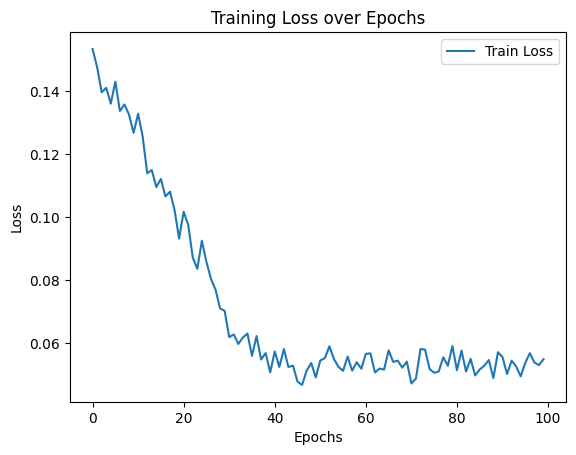

In [ ]:
plot_train_losses(train_losses)

# Testing

In [ ]:
with torch.no_grad():
  for idx, (data, label, index) in enumerate(dataloader):
    data = data.float().to(device)
    label = label.long().to(device)

    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)

    print(predicted)
    print(label)

    break

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 3, 6, 8, 1, 4, 1, 7, 6, 5, 3, 2, 1, 8, 7, 1, 0, 4, 5, 5, 1, 4, 1, 2,
        4, 2, 2, 8, 2, 2, 7, 3, 7, 5, 8, 8, 4, 0, 4, 0, 8, 5, 6, 8, 3, 8, 5, 2,
        8, 3, 2, 5, 0, 1, 1, 0, 0, 0, 8, 8, 2, 2, 5, 4], device='cuda:0')


# Submission